In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer

turkStem = TurkishStemmer()
nltk.download('stopwords')
all_stopwords = stopwords.words('turkish')
all_stopwords += ["a","b","c","ç","d","e","f","g","ğ","h","ı","i","j","k","l","m","n","o","ö","p","r","s","ş","t","u","ü","v","y","z","w","q","bir"]
print(all_stopwords)

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani', 'a', 'b', 'c', 'ç', 'd', 'e', 'f', 'g', 'ğ', 'h', 'ı', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'ö', 'p', 'r', 's', 'ş', 't', 'u', 'ü', 'v', 'y', 'z', 'w', 'q', 'bir']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Bag of words

## Get Data

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np


In [ ]:
filepath = r"/content/drive/MyDrive/data/turkish_data.tsv"

# read the data
dataset = pd.read_csv(filepath, delimiter = '\t', quoting = 3)
# label is nan for some rows, drop them
dataset = dataset.dropna(subset=['label'])
# reset index
dataset = dataset.reset_index(drop=True)

# if label is "non" replace it with 0
dataset['label'] = dataset['label'].replace(['non'], 0)

# if it is anything else replace it with 1
dataset['label'] = dataset['label'].replace(['grp', 'ind', 'prof', "oth"], 1)

print(dataset.head(8))

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset['label'].value_counts()[0]
toxic_count= dataset['label'].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['label'] == 0].head(min_count)
toxic_df = dataset[dataset['label'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
# print("database_lenght is",dataset_length)

# reset index
dataset = dataset.reset_index(drop=True)

# print length of the dataset
# print(len(dataset))

dataset = dataset.iloc[:, 2:]
# print(dataset.columns)

                   id      timestamp  \
0  973568937593065472  1520952977415   
1  973568937723035648  1520952977446   
2  973568937911873536  1520952977491   
3  973568939925090304  1520952977971   
4  973568940667539457  1520952978148   
5  973568943834222592  1520952978903   
6  973568944576585728  1520952979080   
7  973568946086535170  1520952979440   

                                                text  label  
0  @USER06095 Hırsız demişken Tuncay sizin şu 1.2...      1  
1  Ne bileyim sen hastayım deyince bende veterine...      1  
2  Akşam eve gittiğimizde yorgunluğuma iyi gelece...      1  
3  Kook’un sesini 18381 kez dinledikten sonra eğe...      1  
4  @USER05270 @USER04816 o macta adam 6 7 tane ne...      1  
5  #BimVeA101deMazotSatılsın Bim ve a101 kaliteli...      1  
6  Xiumin tam 1 keş. Ne kadar içiyorsa artık insa...      0  
7  @USER02584 @USER09450 Kahvehanede çok muhabbet...      1  


## Cleaning the texts

In [ ]:

# Cleaning the texts
corpus = []

turkStem=TurkishStemmer()

for i in range(0, len(dataset)):
    comment = dataset['text'][i]
    comment = re.sub('[^a-zA-ZğüşıöçĞÜŞİÖÇ]', ' ', comment)
    comment = comment.lower()
    words = comment.split()
    cleaned_words = [turkStem.stemWord(word) for word in words if word not in set(all_stopwords)]
    cleaned_text = ' '.join(cleaned_words)
    corpus.append(cleaned_text)

print(corpus[:5])



['xium tam keş kadar içiyor ar insa vayy diyecek şiş numara yapıyor kadı düşür diyecek dr ev içiyor dddd', 'kız kardeş arkadaş gelip biz kalmış fav olan anlatır', 'user serrodu points assist mac so me yaz serro cokmeyen aglamas', 'vartol diy otomatikma çiğer pert oluyor', 'user saçma anket ada mercedes vito yok üst sevi ter kokul tofaş sormak aynı']


## Creating the Bag of Words model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
cv = CountVectorizer(max_features = 3500)
X = cv.fit_transform(corpus).toarray()

num_words = len(cv.vocabulary_)
print("Number of words:", num_words)

import numpy as np

# Sum up the counts of each word (i.e., sum the columns of X)
word_counts = np.sum(X, axis=0)

# Get the indices of the top 10 words
top_word_indices = np.argsort(word_counts)[::-1][:10]

# Get the feature names
feature_names = cv.get_feature_names_out()

# Get the top 10 words
top_words = [feature_names[i] for i in top_word_indices]

print("Top 10 words:", top_words)

Number of words: 3500
Top 10 words: ['user', 'ol', 'var', 'be', 'ben', 'bi', 'se', 'yok', 'kadar', 'değil']


## Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
y = dataset["label"]
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=1))
print('Recall:', recall_score(y_test, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=1))

[[996 185]
 [524 693]]

Accuracy: 0.7043369474562136
Precision: 0.7892938496583144
Recall: 0.5694330320460148
F1 score: 0.6615751789976134


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf = LogisticRegression(max_iter = 500)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=1))
print('Recall:', recall_score(y_test, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=1))

[[924 257]
 [398 819]]

Accuracy: 0.7268557130942452
Precision: 0.7611524163568774
Recall: 0.6729663105998357
F1 score: 0.7143480156999564


# Word2Vec

In [ ]:
filepath = r"/content/drive/MyDrive/data/turkish_data.tsv"

# read the data
dataset = pd.read_csv(filepath, delimiter = '\t', quoting = 3)
# label is nan for some rows, drop them
dataset = dataset.dropna(subset=['label'])
# reset index
dataset = dataset.reset_index(drop=True)

# if label is "non" replace it with 0
dataset['label'] = dataset['label'].replace(['non'], 0)

# if it is anything else replace it with 1
dataset['label'] = dataset['label'].replace(['grp', 'ind', 'prof', "oth"], 1)

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset['label'].value_counts()[0]
toxic_count= dataset['label'].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['label'] == 0].head(min_count)
toxic_df = dataset[dataset['label'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
print("database_lenght is",dataset_length)

# reset index
dataset = dataset.reset_index(drop=True)

# print length of the dataset
print(len(dataset))

dataset = dataset.iloc[:, 2:]
print(dataset.columns)

database_lenght is 11988
11988
Index(['text', 'label'], dtype='object')


## Split data

In [ ]:
from sklearn.model_selection import train_test_split

# Load the data
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset["label"], test_size=0.2, random_state=42)

## Preprocess the data

In [ ]:
from snowballstemmer import TurkishStemmer

turkStem=TurkishStemmer()

def preprocess(comment):
    comment = re.sub('[^a-zA-ZğüşıöçĞÜŞİÖÇ]', ' ', comment)
    comment = comment.lower()
    words = comment.split()
    cleaned_words = [turkStem.stemWord(word) for word in words if word not in set(all_stopwords)]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

## create the word2vec model

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
print(w2v_model)

Word2Vec<vocab=3568, vector_size=100, alpha=0.025>


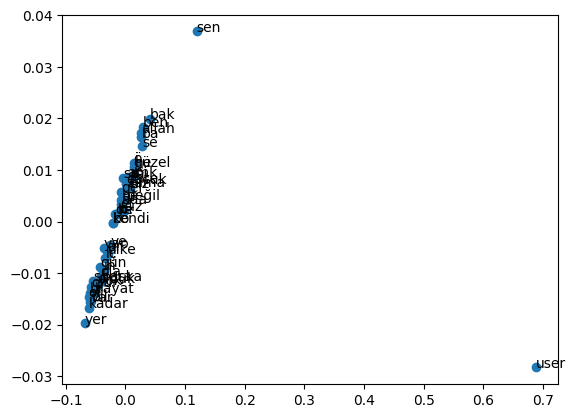

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the 100 most common words
common_words = w2v_model.wv.get_normed_vectors()[:50]

# Fit a PCA transformer to the vector data
pca = PCA(n_components=2)
result = pca.fit_transform(common_words)

# Create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

# Annotate the points on the graph with the words themselves
words = list(w2v_model.wv.index_to_key)[:50]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

In [ ]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=1))
print('Recall:', recall_score(y_test, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=1))

[[506 721]
 [258 913]]

Accuracy: 0.591743119266055
Precision: 0.5587515299877601
Recall: 0.7796754910333049
F1 score: 0.6509803921568627


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=1))
print('Recall:', recall_score(y_test, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=1))

[[402 825]
 [333 838]]

Accuracy: 0.5170975813177648
Precision: 0.5039085989176187
Recall: 0.7156276686592656
F1 score: 0.5913902611150318


# Fine Tuning Bert (binary)


In [ ]:
filepath = r"/content/drive/MyDrive/data/turkish_data.tsv"

# read the data
dataset = pd.read_csv(filepath, delimiter = '\t', quoting = 3)
# label is nan for some rows, drop them
dataset = dataset.dropna(subset=['label'])
# reset index
dataset = dataset.reset_index(drop=True)

# if label is "non" replace it with 0
dataset['label'] = dataset['label'].replace(['non'], 0)

# if it is anything else replace it with 1
dataset['label'] = dataset['label'].replace(['grp', 'ind', 'prof', "oth"], 1)

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset['label'].value_counts()[0]
toxic_count= dataset['label'].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['label'] == 0].head(min_count)
toxic_df = dataset[dataset['label'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
print("database_lenght is",dataset_length)

# reset index
dataset = dataset.reset_index(drop=True)

# print length of the dataset
print(len(dataset))

dataset = dataset.iloc[:, 2:]
print(dataset.columns)

database_lenght is 11988
11988
Index(['text', 'label'], dtype='object')


## Load Trained Model

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/545M [00:00<?, ?B/s]

Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Load Trained Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

## Change Data According to The model

## Split the dataset into training, validation and test

In [ ]:
from sklearn.model_selection import train_test_split


train_texts, temp_texts, train_labels, temp_labels = train_test_split(dataset['text'], dataset['label'],
                                                                    random_state = 2018,
                                                                    test_size = 0.3,
                                                                    stratify = dataset['label'])


val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels,
                                                                random_state = 2018,
                                                                test_size = 0.5,
                                                                stratify = temp_labels)

# print(train_texts.tolist())

In [ ]:
!pip install datasets
from datasets import Dataset, DatasetDict

# Convert lists to datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})  # Replace with your test data
validation_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})  # Replace with your validation data

# Combine datasets into a DatasetDict
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset, 'validation': validation_dataset})


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8391
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1799
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1798
    })
})

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

data_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/8391 [00:00<?, ? examples/s]

Map:   0%|          | 0/1799 [00:00<?, ? examples/s]

Map:   0%|          | 0/1798 [00:00<?, ? examples/s]

In [ ]:
data_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8391
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1799
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1798
    })
})

In [ ]:
data_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

In [ ]:
BATCH_SIZE = 16

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['validation'][:])
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# print a batch from train_dataset
inp, out = next(iter(train_dataset))
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[   2,   36, 4367, ...,    0,    0,    0],
       [   2,   36, 4367, ...,    0,    0,    0],
       [   2, 5330, 2733, ...,    0,    0,    0],
       ...,
       [   2, 4642, 6282, ...,    0,    0,    0],
       [   2,   36, 4367, ...,    0,    0,    0],
       [   2,   36, 4367, ...,    0,    0,    0]])>, 'attention_mask': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

 tf.Tensor([0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int64)


In [ ]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [ ]:
classifier = BERTForClassification(model, num_classes=2)

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
history = classifier.fit(
    train_dataset,
    epochs = 2,
    validation_data = val_dataset
)

Epoch 1/2
525/525 [==============================] - 550s 913ms/step - loss: 0.5734 - accuracy: 0.6781 - val_loss: 0.3945 - val_accuracy: 0.8326
Epoch 2/2
525/525 [==============================] - 487s 927ms/step - loss: 0.3722 - accuracy: 0.8351 - val_loss: 0.3684 - val_accuracy: 0.8448


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = classifier.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

113/113 [==============================] - 21s 151ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('\nAccuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred, pos_label=1))
print('Recall:', recall_score(y_true, y_pred, pos_label=1))
print('F1 score:', f1_score(y_true, y_pred, pos_label=1))


[[736 164]
 [117 782]]

Accuracy: 0.8438021122846026
Precision: 0.8266384778012685
Recall: 0.8698553948832035
F1 score: 0.8476964769647696


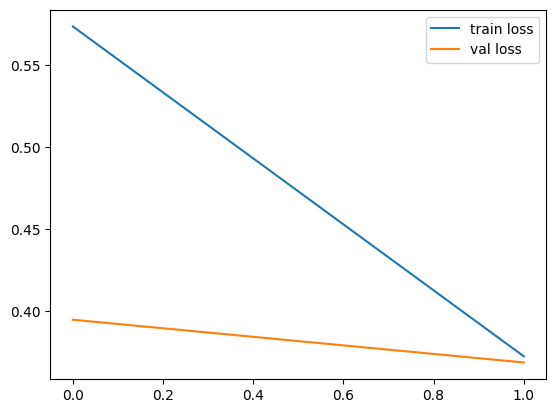

In [ ]:
# plot loss, accuracy, trainin, validation and , test
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

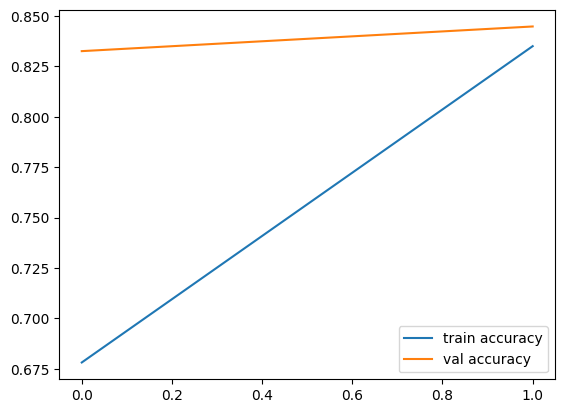

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')

plt.legend()
plt.show()

In [ ]:
classifier.save("bert_model1")